In [8]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [3]:
# display the image in proper resolution

def display(img):

    dpi = 80
    data = plt.imread(img)
    height, width, depth = data.shape

    figsize = width/ float(dpi), height/ float(dpi)

    fig = plt.figure(figsize= figsize)

    ax = fig.add_axes([0, 0, 1, 1])

    ax.axis("off")

    ax.imshow(data, cmap= "gray")

    plt.show()

In [9]:
def getSkewAngle(img):

    img2 = img.copy()
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #blur = cv2.GaussianBlur(gray, (1, 1), 0)
    adaptive_threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 5)
    #thresh = cv2.threshold(blur,50, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    cv2.imshow("frame", adaptive_threshold)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    #dilate = cv2.dilate(blur, kernel, iterations=1)
   
    contours, hierarchy = cv2.findContours(adaptive_threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key= cv2.contourArea, reverse= True)

    print(len(contours))
    for c in contours:

        rect = cv2.boundingRect(c)
        x, y, h, w = rect
        cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    largestContour = contours[3]
    rect = cv2.boundingRect(largestContour)
    x, y, h, w = rect
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.imshow("frame", img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    minAreaRect = cv2.minAreaRect(largestContour)

    angle = minAreaRect[-1]
    print("___", angle)
    if angle < -45:

        angle = 90 + angle

    return -1.0*angle


def rotateImage(img, angle: float):

    img2 = img.copy()

    (h, w) = img.shape[:2]

    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    new_image = cv2.warpAffine(img2, M, (w, h), flags= cv2.INTER_CUBIC, borderMode= cv2.BORDER_REPLICATE)

    return new_image

In [10]:
def deskew(img):
    angle = getSkewAngle(img)
    return rotateImage(img, -1.0*angle)

940
___ 8.130102157592773


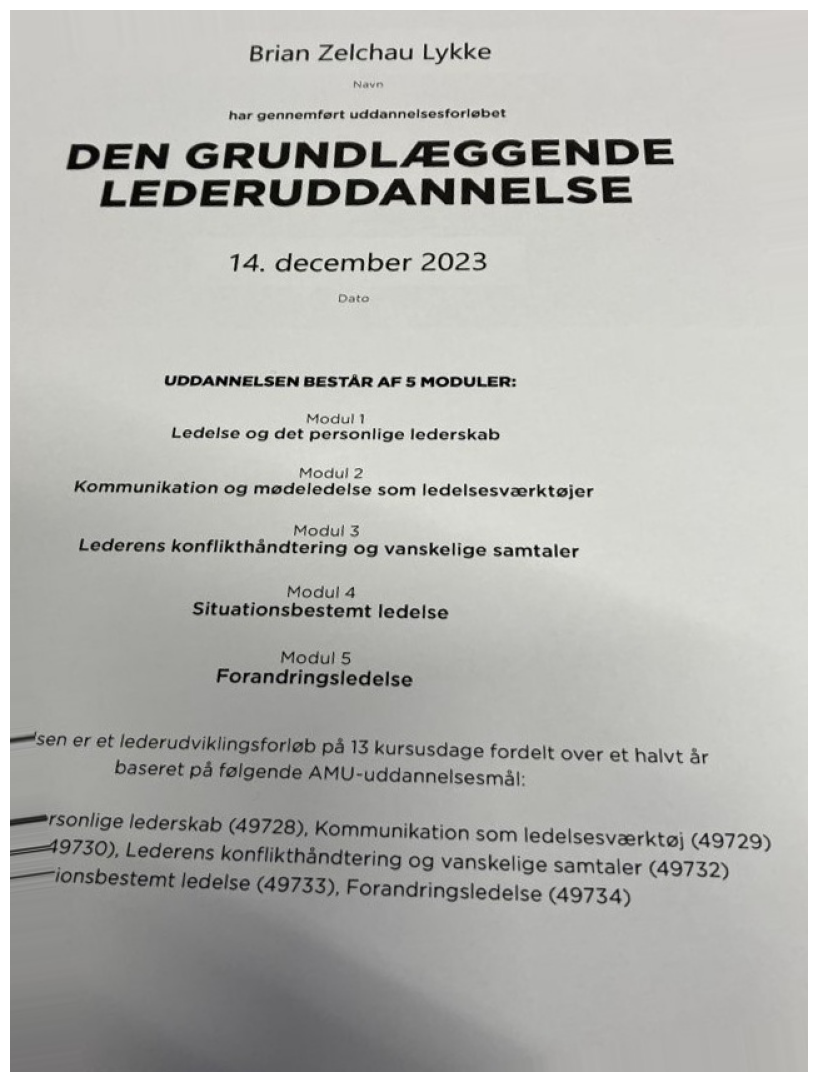

In [12]:
img = cv2.imread("check_rotation1.jpeg")
#contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#len(contours)
rotated_image = deskew(img)
cv2.imwrite("rotated.jpg", rotated_image)
display("rotated.jpg")

In [9]:
def noise_removal(img):

    kernel = np.ones((1,1), np.uint8)
    image = cv2.dilate(img, kernel, iterations=1)
    kernel = np.ones((1,1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)

    return image

In [ ]:
def thin_font(img):

    image = cv2.bitwise_not(img)
    kernel = np.ones((2,2), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)

    return image

In [ ]:
def thick_font(img):

    image = cv2.bitwise_not(img)
    kernel = np.ones((2,2), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)

    return image

In [ ]:
def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int):
  
    assert img.ndim == 2
    assert img.dtype == np.uint8

    
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

   
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:
        
        if cv2.contourArea(c) < min_area:
            continue
       
        x, y, w, h = cv2.boundingRect(c) 
        crop = img[y:y + h, x:x + w]
        res.append((crop, (x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel